# RNN으로 간단한 텍스트 분류기 만들기

# 1. RNN 이란?

Recurrent Neural network (RNN)으로 우리나라 말로는 순환 신경망이라고 한다. 이는 똑같은 완전 연결층이 반복되는 구조를 가진다.

이를 통해 연속되는 입력 데이터를 받아 데이터의 순차적인 연관성을 학습할 수 있도록 한다.

## 1.1 RNN의 작동 원리

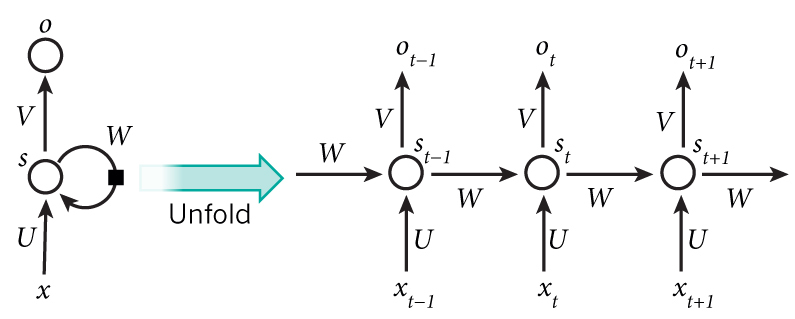

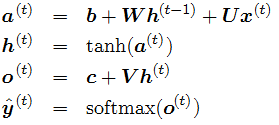

위 그림을 예시로 들어 RNN의 작동원리를 이해해보자.

1. 입력 데이터 $x$ 는 각 시간 스텝 $t$ 별로 $x_t$ 을 가지며 동일한 가중치 신경망 $U$ 의 입력으로 사용된다.

2. 그리고 이전 입력 데이터 $x_{<t}$의 정보를 받기 위해서 이전 스텝 계산에서 계산하는 히든 상태 $h_{t-1}$ 을 제공 받는다. (이떄 사용되는 신경망의 가중치는 $W$ 로 각 스텝별 히든 상태 정보를 전달하기 위한 용도로 사용된다.)

3. 마지막으로 각 시간 스텝별 출력값을 얻기 위한 신경망인 $V$ 가 존재하며 이 또한 모든 스텝에서 동일하게 사용되어진다.

4. 신경망 모델의 비선형성을 위해 사용하는 활성화 함수의 경우 tanh을 사용하며 이는 기울기 증폭 및 축소 현상을 완화시켜준다.

# 1.2 간단한 텍스트 분류기 만들기 위한 데이터 전처리

신경망 모델에서 텍스트를 다루기 위해서는 텍스트를 그에 맞는 숫자로 바꾸고 신경망 학습에 적합한 크기로 변경시켜야 한다.

이를 위해서 다음의 데이터 전처리 과정이 필요하다.
1. 토크나이즈 (tokenize) : 각 글자를 최소 단위로 잘라 숫자에 맵핑시키는 작업
2. 학습 데이터 길이 균일화 : 배치 단위의 학습을 위해서 동일한 길이의 시퀀스로 입력 데이터를 준비



In [15]:
!pip install -U datasets

## 1.2.1 데이터셋 구축하기

In [16]:
from datasets import load_dataset

# IMDB 데이터셋 로드
dataset = load_dataset("imdb")

# text 데이터만 불러오기
train_texts = [x['text'] for x in dataset['train']]
test_texts = [x['text'] for x in dataset['test']]

단어 단위 (띄어쓰기) 로 문장을 잘라서 각각 대표되는 숫자에 대응되도록 쌍을 만들어 준다.

In [18]:
# # 단어 집합 생성 (train 데이터 기준)
def word_tokenizer(text):
    return text.lower().split()

all_words = []
for text in train_texts:
    all_words.extend(word_tokenizer(text))
vocab = sorted(list(set(all_words)))
word2idx = {w: i+2 for i, w in enumerate(vocab)}  # 0: <pad>, 1: <unk>
word2idx['<pad>'] = 0 # default token number
word2idx['<unk>'] = 1 # default token number
idx2word = {i: w for w, i in word2idx.items()}
vocab_size = len(word2idx)

In [19]:
print("number of vocab:", vocab_size)
print("word dict:", word2idx)

251639
{'\x08\x08\x08\x08a': 2, '\x10own': 3, '!': 4, '!!': 5, '!!!': 6, '!!!!': 7, '!!!!!': 8, '!!!!!!': 9, '!!!!!!!': 10, '!!!!!!!!': 11, '!!!!!!!!!': 12, '!!!!!!!!!!': 13, '!!!!!!!!!!!': 14, '!!!!!!!!!!!!!': 15, '!!!!!!!!!!!!!!': 16, '!!!!!!!!!!!!!!!!!!!!!!': 17, '!!!!!!!!!!!!!!!!!!!!!!!!!!': 18, '!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!': 19, '!!!!!!!<br': 20, '!!!!!<br': 21, '!!!!"': 22, '!!!!<br': 23, '!!!)': 24, '!!!.<br': 25, '!!!7!!!': 26, '!!!<br': 27, '!!!scott': 28, '!!"': 29, '!!",': 30, '!!).': 31, '!!)<br': 32, '!!*<br': 33, '!!,': 34, '!!-': 35, '!!.': 36, '!!....<br': 37, '!!<br': 38, '!!?': 39, '!!??': 40, '!"': 41, '!",': 42, '!".': 43, '!)': 44, '!),': 45, '!).': 46, '!).<br': 47, '!,': 48, '!.': 49, '!....both': 50, '!.<br': 51, '!<br': 52, '!?': 53, '!?!?!?!?!?': 54, '!the': 55, '"': 56, '""beat': 57, '""housesitter",': 58, '""leave': 59, '""shin': 60, '"$"': 61, '"&#269;etvorka"': 62, '"&$*@$': 63, '"\'70s"': 64, '"\'bright': 65, '"\'cause': 66, '"\'menaikkan\'': 67, '"\'

## 1.2.2 단어 단위로 토크나이징하기

In [20]:
import torch

max_len = 100  # 최대 문장 길이

def encode_text(text, max_len=max_len):
    tokens = word_tokenizer(text)
    indices = [word2idx.get(w, 1) for w in tokens[:max_len]]  # <unk> = 1
    if len(indices) < max_len:
        indices += [0] * (max_len - len(indices))  # <pad> =
    return torch.tensor(indices, dtype=torch.long)

def encode_label(label):
    return torch.tensor(label, dtype=torch.float)

## 1.2.3 torch dataset 세팅하기
- pytorch의 데이터 로더를 사용하기 위해 필요함.
- \_\_init\_\_ : 사용할 데이터셋을 추가
- \_\_len\_\_ : 데이터셋 크기
- \_\_getitem\_\_ : 랜덤으로 데이터셋에서 텍스트 데이터 및 라벨 불러오기

In [21]:
from torch.utils.data import Dataset

class IMDBCharDataset(Dataset):
    def __init__(self, split):
        self.data = dataset[split]
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        text = self.data[idx]['text']
        label = self.data[idx]['label']
        return encode_text(text), encode_label(label)

# 1.2.4 RNN 모델 구성하기

- nn.embedding : 턱스트 인덱스를 벡터화하는 층 (학습)
- nn.RNN : RNN layer
- nn.Linear : 완전 연결 층

In [22]:
import torch.nn as nn

class simple_RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        # self.rnn = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        # self.rnn = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x: (batch, seq_len)
        emb = self.embedding(x)  # (batch, seq_len, embed_dim)
        _, h_n = self.rnn(emb)   # h_n: (1, batch, hidden_dim)
        out = self.fc(h_n.squeeze(0))  # (batch, num_classes)
        return out.squeeze(1)          # (batch)

In [23]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch [1/10], Train Loss: 0.6992, Val Loss: 0.6955. Correct: 0.4972
Epoch [2/10], Train Loss: 0.6866, Val Loss: 0.6965. Correct: 0.5117
Epoch [3/10], Train Loss: 0.6731, Val Loss: 0.6986. Correct: 0.5238
Epoch [4/10], Train Loss: 0.6426, Val Loss: 0.7173. Correct: 0.5415
Epoch [5/10], Train Loss: 0.5768, Val Loss: 0.7252. Correct: 0.5779
Epoch [6/10], Train Loss: 0.5020, Val Loss: 0.7492. Correct: 0.6022
Epoch [7/10], Train Loss: 0.4182, Val Loss: 0.7885. Correct: 0.6228
Epoch [8/10], Train Loss: 0.3599, Val Loss: 0.8167. Correct: 0.6102
Epoch [9/10], Train Loss: 0.3066, Val Loss: 0.8510. Correct: 0.6282
Epoch [10/10], Train Loss: 0.3036, Val Loss: 0.8790. Correct: 0.6254


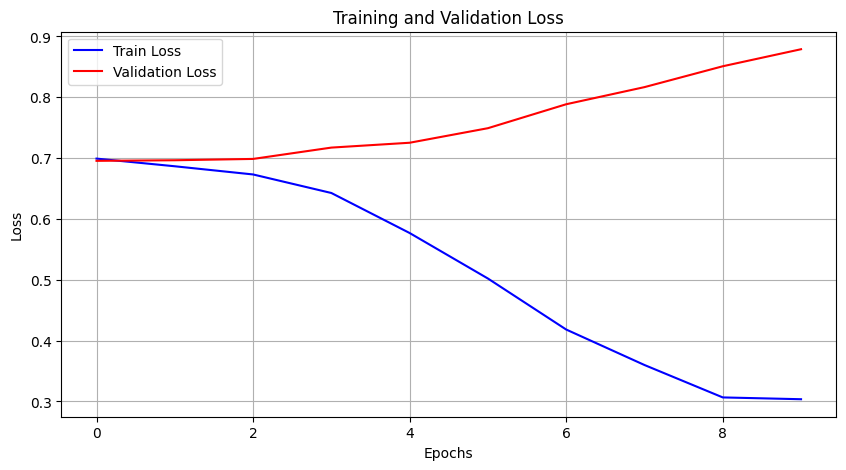

In [24]:
embed_dim = 64 # 문자 임베딩 차원
hidden_dim = 16 # RNN 은닉 상태 차원
batch_size = 64 # 배치 사이즈
lr = 1e-3 # 학습률
epochs = 10 # 애폭

from torch.utils.data import DataLoader

# dataset 만들기
train_dataset = IMDBCharDataset("train")
test_dataset = IMDBCharDataset("test")

# 데이터 로더 준비
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# 모델 불러오기
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = simple_RNN(vocab_size, embed_dim, hidden_dim).to(device)

# 손실함수 및 옵티마이져
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# 손실 기록 리스트
train_losses = []
val_losses = []

# 학습
for epoch in range(epochs):
    model.train() # 학습을 알리는 flag
    running_loss = 0.0 # epoch 마다 평균 loss값 측정

    for texts, labels in train_loader:
        texts = texts.to(device) # (batch, seq_length)
        labels = labels.to(device)

        logits = model(texts)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # 검증
    model.eval() # 을 알리는 flag
    val_loss = 0.0
    correct = 0.0
    total = 0.0

    with torch.no_grad():
        for texts, labels in test_loader:
            texts = texts.to(device) # (batch, seq_length)
            labels = labels.to(device)

            logits = model(texts)
            loss = criterion(logits, labels)

            preds = torch.round(torch.sigmoid(logits))
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            val_loss += loss.item()
    val_losses.append(val_loss / len(test_loader))

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}. Correct: {correct/total:.4f}')


# 손실값 시각화
plot_losses(train_losses, val_losses)

In [25]:
def predict_sentiment(model, text):
    model.eval()
    with torch.no_grad():
        x = encode_text(text).unsqueeze(0).to(device)
        logit = model(x)
        prob = torch.sigmoid(logit).item()
        return "positive" if prob > 0.5 else "negative", prob

In [26]:
# 학습 후 예측 예시
print(predict_sentiment(model, "This movie was fantastic!"))
print(predict_sentiment(model, "I hated this film."))

('positive', 0.8870450854301453)
('negative', 0.10731220245361328)
